# Training Computer Vision Models on Amazon SageMaker

## Setup

In [ ]:
# install tree command (helpful in printing folder structures)
!apt-get install tree

# setup AWS cli
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/d01_admin/* ~/.aws
!chmod 600 ~/.aws/credentials
!pip install awscli

# install boto3 and sagemaker
!pip install boto3
!pip install sagemaker

# install dependencies
!pip install pyathena
!pip install awswrangler
!pip install smclarify
!pip install sagemaker-experiments
!pip install sagemaker-tensorflow
!pip install smclarify
!pip install stepfunctions

# install nlp libs
!pip install transformers

In [84]:
# imports
import boto3
import sagemaker
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import io
import os
import sys
import time
import json
import csv
import sagemaker.amazon.common as smac
from sagemaker.image_uris import retrieve
from scipy.sparse import lil_matrix
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import JSONSerializer
from sagemaker.multidatamodel import MultiDataModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

In [97]:
# global variables
role = "sagemakerRole"
prefix = "sagemaker-exp11061330"
training_instance_type = "ml.m5.xlarge"

In [81]:
# setup sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role_arn = "arn:aws:iam::{}:role/{}".format(account_id, role)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)
runtime = boto3.Session().client(service_name='runtime.sagemaker')
runtime_sm_client = boto3.client('sagemaker-runtime')

## Image Classification on Caltech-256

In [98]:
!wget -q --show-progress http://data.mxnet.io/data/caltech-256/caltech-256-60-train.rec
!wget -q --show-progress http://data.mxnet.io/data/caltech-256/caltech-256-60-val.rec

caltech-256-60-trai 100%[===================>] 346.78M  19.3MB/s    in 19s     
caltech-256-60-val. 100%[===================>] 343.55M  19.3MB/s    in 19s     


In [99]:
s3_train_path = sess.upload_data(path='caltech-256-60-train.rec', bucket=bucket, key_prefix=prefix+'/input/train')
s3_val_path = sess.upload_data(path='caltech-256-60-val.rec',   bucket=bucket, key_prefix=prefix+'/input/validation')
s3_output = 's3://{}/{}/output'.format(bucket, prefix)

print(s3_train_path)
print(s3_val_path)
print(s3_output)

s3://sagemaker-us-east-1-390354360073/sagemaker-exp11061330/input/train/caltech-256-60-train.rec
s3://sagemaker-us-east-1-390354360073/sagemaker-exp11061330/input/validation/caltech-256-60-val.rec
s3://sagemaker-us-east-1-390354360073/sagemaker-exp11061330/output


In [104]:
container = retrieve('image-classification', region)
print(container)

ic = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type='ml.m4.2xlarge',
    output_path=s3_output)

ic.set_hyperparameters(
    num_layers=50,               # Train a Resnet-18 model
    use_pretrained_model=1,      # Train from scratch
    num_classes=257,             # 256 classes + 1 clutter class
    num_training_samples=15240,  # Number of training samples
    learning_rate=0.001,
    epochs=5)

train_data = sagemaker.TrainingInput(
    s3_train_path, 
    content_type='application/x-recordio')

validation_data = sagemaker.TrainingInput(
    s3_val_path,
    content_type='application/x-recordio')

s3_channels = {'train': train_data, 'validation': validation_data}

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


In [ ]:
ic.fit(inputs=s3_channels)

In [ ]:
ic_predictor = ic.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium')

--2022-06-11 08:12:04--  https://upload.wikimedia.org/wikipedia/commons/b/b7/LabradorWeaving.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128484 (125K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>] 125.47K  --.-KB/s    in 0.02s   

2022-06-11 08:12:05 (8.16 MB/s) - ‘/tmp/test.jpg’ saved [128484/128484]



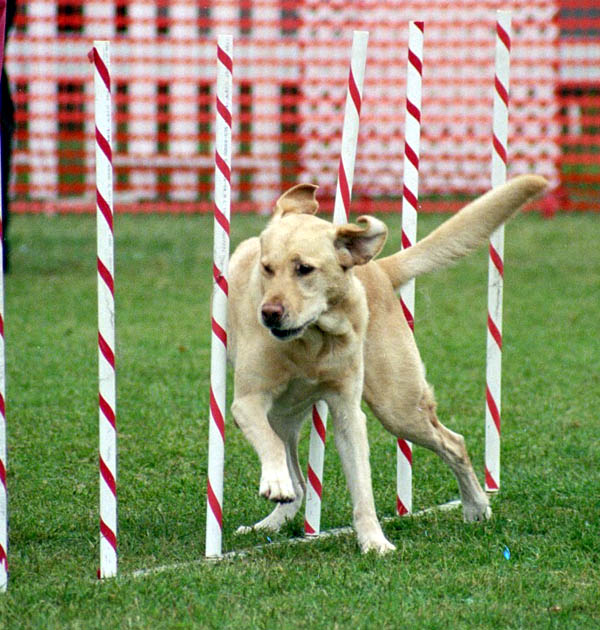

In [106]:
!wget -O /tmp/test.jpg https://upload.wikimedia.org/wikipedia/commons/b/b7/LabradorWeaving.jpg
file_name = '/tmp/test.jpg'
from IPython.display import Image
Image(file_name)

In [ ]:
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

response = runtime.invoke_endpoint(EndpointName=ic_predictor.endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)

result = response['Body'].read()
result = json.loads(result)
index = np.argmax(result)
print(result[index], index)

## Object Detection with Pascal VOC

In [ ]:
!wget https://data.deepai.org/PascalVOC2012.zip
!unzip PascalVOC2012.zip

!mkdir input
%cd input
!mkdir train validation train_annotation validation_annotation

In [112]:
%%sh
for file in `cat ../VOC2012/ImageSets/Segmentation/train.txt | xargs`; do cp ../VOC2012/JPEGImages/$file".jpg" train; done
for file in `cat ../VOC2012/ImageSets/Segmentation/val.txt | xargs`; do cp ../VOC2012/JPEGImages/$file".jpg" validation; done
for file in `cat ../VOC2012/ImageSets/Segmentation/train.txt | xargs`; do cp ../VOC2012/SegmentationClass/$file".png" train_annotation; done
for file in `cat ../VOC2012/ImageSets/Segmentation/val.txt | xargs`; do cp ../VOC2012/SegmentationClass/$file".png" validation_annotation; done
for dir in train train_annotation validation validation_annotation; do find $dir -type f | wc -l; done

1464
1464
1449
1449


In [113]:
!aws s3 sync . s3://{bucket}/pascalvoc-segmentation/input/

upload: validation_annotation/2011_001060.png to s3://sagemaker-us-east-1-390354360073/pascalvoc-segmentation/input/validation_annotation/2011_001060.png
upload: validation_annotation/2011_001064.png to s3://sagemaker-us-east-1-390354360073/pascalvoc-segmentation/input/validation_annotation/2011_001064.png
upload: validation_annotation/2011_001069.png to s3://sagemaker-us-east-1-390354360073/pascalvoc-segmentation/input/validation_annotation/2011_001069.png
upload: validation_annotation/2011_001082.png to s3://sagemaker-us-east-1-390354360073/pascalvoc-segmentation/input/validation_annotation/2011_001082.png
upload: validation_annotation/2011_001071.png to s3://sagemaker-us-east-1-390354360073/pascalvoc-segmentation/input/validation_annotation/2011_001071.png
upload: validation_annotation/2011_001110.png to s3://sagemaker-us-east-1-390354360073/pascalvoc-segmentation/input/validation_annotation/2011_001110.png
upload: validation_annotation/2011_001159.png to s3://sagemaker-us-east-1-39

In [115]:
s3_train_data = 's3://{}/{}/input/train'.format(bucket, prefix)
s3_validation_data = 's3://{}/{}/input/validation'.format(bucket, prefix)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

print(s3_train_data)
print(s3_validation_data)

s3://sagemaker-us-east-1-390354360073/sagemaker-exp11061330/input/train
s3://sagemaker-us-east-1-390354360073/sagemaker-exp11061330/input/validation


In [ ]:
container = retrieve('object-detection', region)
print(container)

od = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(), 
    instance_count=1, 
    instance_type='ml.p3.2xlarge',
    output_path=s3_output_location)

od.set_hyperparameters(
    base_network='resnet-50',
    use_pretrained_model=1,
    num_classes=20,
    epochs=30,
    num_training_samples=16551)

train_data = TrainingInput(
    s3_train_data, 
    content_type='application/x-recordio')

validation_data = TrainingInput(
    s3_validation_data,
    content_type='application/x-recordio')

data_channels = {'train': train_data, 'validation': validation_data}

od.fit(inputs=data_channels)

In [ ]:
od_predictor = od.deploy(
    initial_instance_count = 1,
    instance_type = 'ml.c5.2xlarge')

In [ ]:
!wget -q --show-progress -O test.jpg https://bit.ly/3hu8kYi
    
filename = 'test.jpg'    
with open(filename, 'rb') as image:
    f = image.read()
    b = bytearray(f)

In [ ]:
with open(filename, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

response = runtime.invoke_endpoint(EndpointName=od_predictor.endpoint_name, 
                                   ContentType='image/jpeg', 
                                   Body=payload)

response = response['Body'].read()
response = json.loads(response)

In [ ]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

In [ ]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
                     'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
                     'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.30

# Visualize the detections.
visualize_detection('test.jpg', response['prediction'], object_categories, threshold)

## Semantic Segmentation with Pascal VOC

In [116]:
s3_train_data = 's3://{}/{}/input/train'.format(bucket, prefix)
s3_validation_data = 's3://{}/{}/input/validation'.format(bucket, prefix)
s3_train_annotation_data = 's3://{}/{}/input/train_annotation'.format(bucket, prefix)
s3_validation_annotation_data = 's3://{}/{}/input/validation_annotation'.format(bucket, prefix)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

print(s3_train_data)
print(s3_validation_data)
print(s3_train_annotation_data)
print(s3_validation_annotation_data)

s3://sagemaker-us-east-1-390354360073/sagemaker-exp11061330/input/train
s3://sagemaker-us-east-1-390354360073/sagemaker-exp11061330/input/validation
s3://sagemaker-us-east-1-390354360073/sagemaker-exp11061330/input/train_annotation
s3://sagemaker-us-east-1-390354360073/sagemaker-exp11061330/input/validation_annotation


In [ ]:
container = retrieve('semantic-segmentation', region)

seg = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    instance_count = 1, 
    instance_type = 'ml.p3.2xlarge',
    output_path = s3_output_location)

seg.set_hyperparameters(
    backbone='resnet-50', 
    algorithm='fcn',              
    use_pretrained_model=True, 
    num_classes=21,
    epochs=30,
    num_training_samples=1464)

train_data = TrainingInput(
    s3_train_data, distribution='FullyReplicated', 
    content_type='image/jpeg')

validation_data = TrainingInput(
    s3_validation_data,
    content_type='image/jpeg')

train_annotation = TrainingInput(
    s3_train_annotation_data,
    content_type='image/png')

validation_annotation = TrainingInput(
    s3_validation_annotation_data,
    content_type='image/png')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation':validation_annotation}

In [ ]:
seg.fit(inputs=data_channels)

In [ ]:
seg_predictor = seg.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.2xlarge')

In [ ]:
!wget -O test.jpg https://upload.wikimedia.org/wikipedia/commons/e/ea/SilverMorgan.jpg
filename = 'test.jpg'

im = Image.open(filename)
im.save(filename, "JPEG")

plt.imshow(im)
plt.axis('off')

In [ ]:
runtime = boto3.Session().client(service_name='runtime.sagemaker')

with open(filename, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

response = runtime.invoke_endpoint(EndpointName=seg_predictor.endpoint_name, 
                                   ContentType='image/jpeg', 
                                   Accept='image/png', 
                                   Body=payload)

result = response['Body'].read()

In [ ]:
num_classes = 21
mask = np.array(Image.open(io.BytesIO(result)))
plt.imshow(mask, vmin=0, vmax=num_classes-1, cmap='gray_r')
plt.show()

In [ ]:
response = runtime.invoke_endpoint(EndpointName=seg_predictor.endpoint_name, 
                                   ContentType='image/jpeg', 
                                   Accept='application/x-protobuf', 
                                   Body=payload)

result = response['Body'].read()

results_file = 'results.rec'
with open(results_file, 'wb') as f:
    f.write(result)